In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from pathlib import Path
from tqdm import tqdm
import PIL
import os
print("Imported Successfully")

Imported Successfully


In [2]:
# import each path of the image classes
glaucoma = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\glaucoma')
cataract = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\cataract')
normal = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\normal')
diabetic_retinopathy = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy')

In [3]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

C:\Users\swapn\OneDrive\Desktop\dataset\normal: 100%|██████████| 1074/1074 [00:00<00:00, 2384.48it/s]
C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 2835.67it/s]


In [4]:
df

,image,disease_type
0,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
1,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
2,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
3,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
4,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
...,...,...
4385,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4386,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4387,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4388,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3


In [5]:
df.disease_type.value_counts()

0    1211
3    1098
2    1074
1    1007
Name: disease_type, dtype: int64

In [6]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

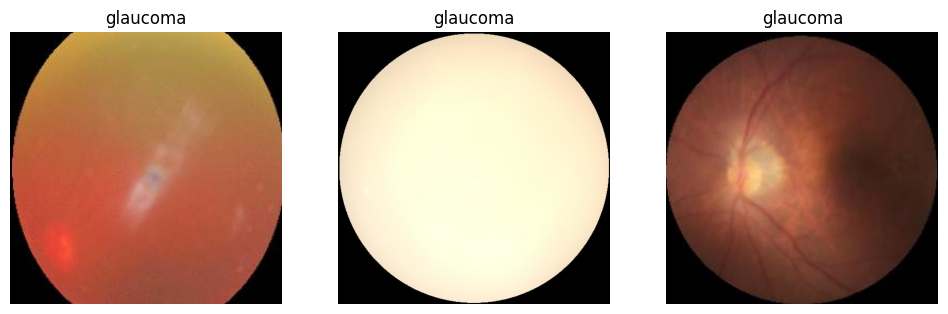

In [7]:
plot_image(0)

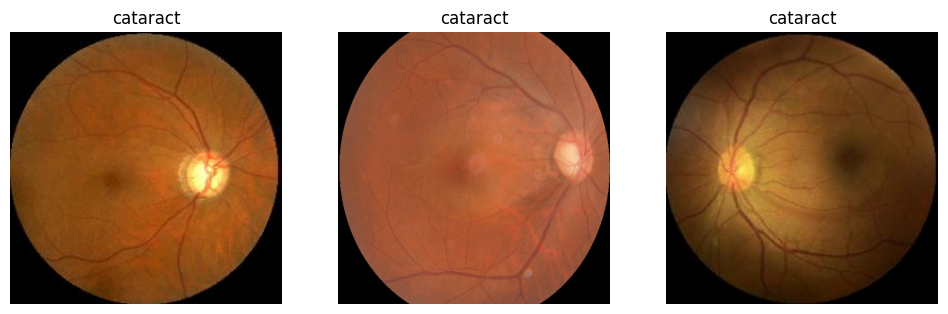

In [8]:
plot_image(1)

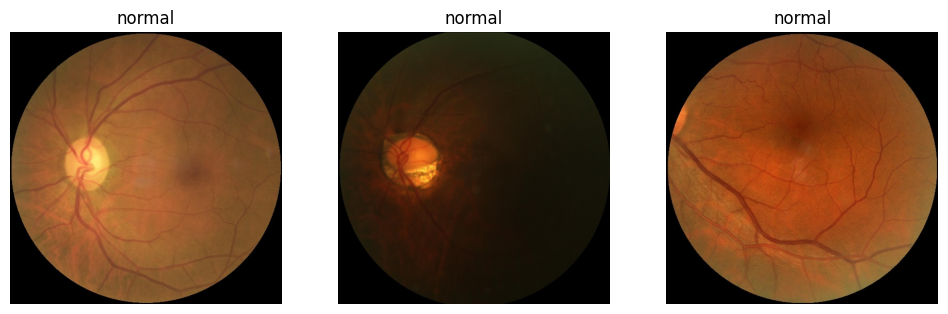

In [9]:
plot_image(2)

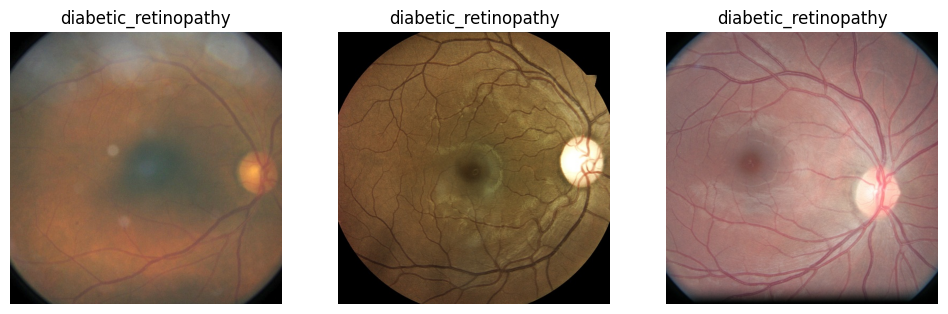

In [10]:
plot_image(3)

In [11]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

glaucoma                1211
diabetic_retinopathy    1098
normal                  1074
cataract                1007
Name: disease_type, dtype: int64

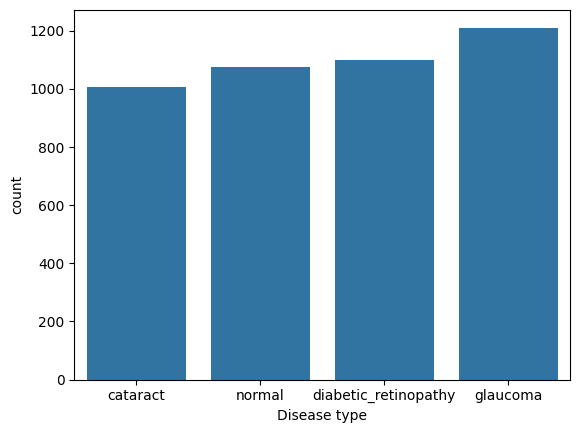

In [12]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [13]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3511 validated image filenames belonging to 4 classes.


c:\Users\swapn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [15]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 877 validated image filenames belonging to 4 classes.


c:\Users\swapn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [19]:
labels = [key for key in train_data.class_indices]
num_classes = len(disease_type)

# Load the VGG-16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [20]:
# Create the model using the VGG-16 base model
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 3211908 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:

# Fitting the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15
)

Epoch 1/15
110/110 [==============================] - 866s 8s/step - loss: 0.3494 - accuracy: 0.8690 - val_loss: 0.5698 - val_accuracy: 0.8210
Epoch 2/15
110/110 [==============================] - 551s 5s/step - loss: 0.2155 - accuracy: 0.9163 - val_loss: 0.5509 - val_accuracy: 0.8540
Epoch 3/15
110/110 [==============================] - 262s 2s/step - loss: 0.1553 - accuracy: 0.9433 - val_loss: 0.6930 - val_accuracy: 0.8130
Epoch 4/15
110/110 [==============================] - 263s 2s/step - loss: 0.1306 - accuracy: 0.9490 - val_loss: 0.6075 - val_accuracy: 0.8461
Epoch 5/15
110/110 [==============================] - 262s 2s/step - loss: 0.1246 - accuracy: 0.9553 - val_loss: 0.5771 - val_accuracy: 0.8415
Epoch 6/15
110/110 [==============================] - 263s 2s/step - loss: 0.0977 - accuracy: 0.9578 - val_loss: 0.6420 - val_accuracy: 0.8438
Epoch 7/15
110/110 [==============================] - 263s 2s/step - loss: 0.1010 - accuracy: 0.9541 - val_loss: 0.6491 - val_accuracy: 0.8381

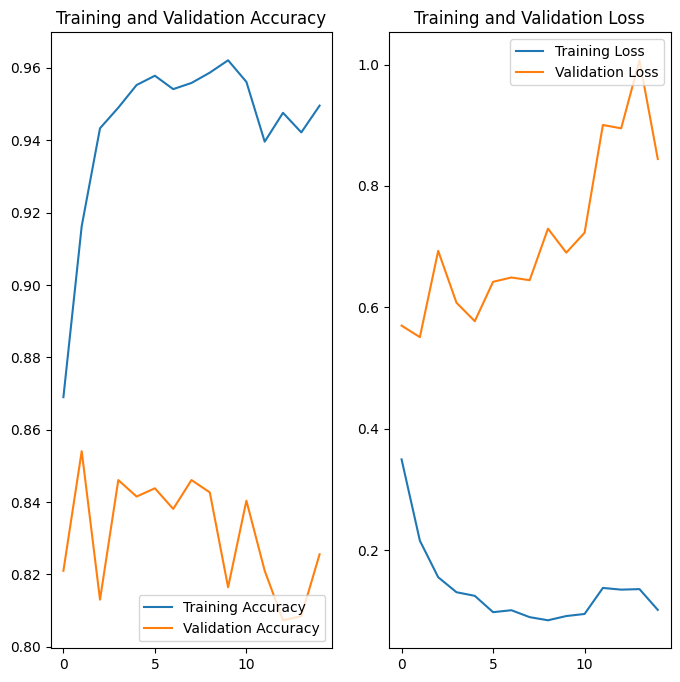

In [23]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

28/28 [==============================] - 47s 2s/step


In [25]:
model.save("VGG16ML_CODE.tf")

INFO:tensorflow:Assets written to: VGG16ML_CODE.tf\assets


INFO:tensorflow:Assets written to: VGG16ML_CODE.tf\assets


In [26]:
loaded_model = tf.keras.models.load_model('VGG16ML_CODE.tf')

In [27]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model requirements
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Provide the path to your image
image_path = r'C:\Users\swapn\Downloads\diabetic_retinopathy_1.jpg'  # Replace with the actual path to your image

# Preprocess the image
processed_image = preprocess_image(image_path)
predictions = loaded_model.predict(processed_image)
disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
df_predict = pd.DataFrame(predictions)
max_values_per_row = df_predict.idxmax(axis=1)
m = [disease_labels[i] for i in max_values_per_row]
print(m)

1/1 [==============================] - 0s 238ms/step
['cataract']


In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

g_dict = valid_data.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(valid_data.classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

#plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(valid_data.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

            cataract       0.86      0.72      0.78       201
diabetic_retinopathy       0.82      0.92      0.87       203
            glaucoma       0.86      0.77      0.81       255
              normal       0.78      0.90      0.84       218

            accuracy                           0.83       877
           macro avg       0.83      0.83      0.82       877
        weighted avg       0.83      0.83      0.82       877

